# Normalize operator

This notebook illustrates the usage of `Normalize` operator.

## Introduction
Normalization is the process of shifting and scaling the data values to match desired distribution. It is done by calculating the mean $\mu$ and standard deviation $\sigma$ and modifying the data as follows:

$$Y_i = \frac{X_i - \mu}{\sigma}$$

There are more advanced features in `Normalize`, which we'll explore after we've had the first glance at Normalize in its default setting.

## Using the `Normalize` operator

First, we need some boilerplate code to import DALI and some other useful libraries and also to visualize the results.

In [1]:
from nvidia.dali.pipeline import Pipeline
import math
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
import nvidia.dali.backend as backend

batch_size = 10
image_filename = "../data/images"

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def display(outputs, idx, columns = 2, captions = None):
    rows = int(math.ceil(len(outputs) / columns))
    fig = plt.figure()
    fig.set_size_inches(16, 6 * rows)
    gs = gridspec.GridSpec(rows, columns)
    row = 0
    col = 0
    for i, out in enumerate(outputs):
        if isinstance(out, backend.TensorListGPU):
            out = out.as_cpu()
        plt.subplot(gs[i])
        plt.axis("off")
        if captions is not None:
            plt.title(captions[i])
        plt.imshow(out.at(idx));
        
def show(pipe_class, idx, columns = 2, captions = None):
    pipe = pipe_class(batch_size=batch_size, num_threads=1, device_id=0)
    pipe.build()
    display(pipe.run(), idx, columns, captions)


### A simple pipeline

Let's start with a simple pipeline which just loads some images and normalizes their dynamic range.

In [2]:
class NormalizeSimple(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(NormalizeSimple, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(file_root=image_filename)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        self.norm = ops.Normalize(device="gpu")

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        normalized = self.norm(image)
        return image, normalized

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


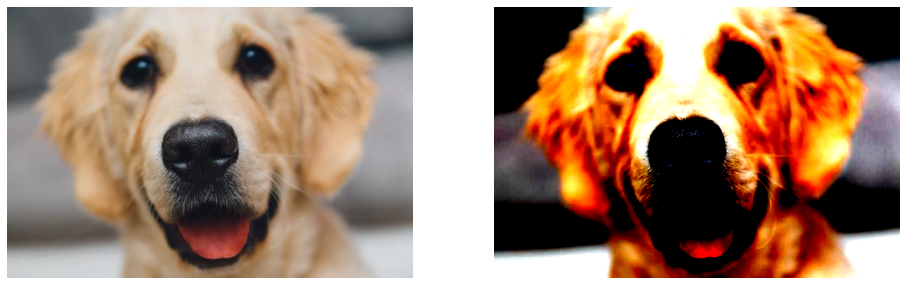

In [3]:
show(NormalizeSimple, 1)

## Adjusting output dynamic range
As you can see in the example above, the image intensity values have been scaled and shifted, with many pixels forced below 0 (and displayed as black).
This may be desired in many use cases, but if the output type has limited dynamic range (e.g. `uint8`), we may want to map the mean and standard deviation to values that more effectively utilize that limited range of values.
For this purpose, `Normalize` offers two scalar arguments: `shift` and `scale`. Now the normalization formula becomes:

$$Y_i = \frac{X_i - \mu}{\sigma} \cdot {scale} + {shift}$$

Let's modify the pipeline to produce `uint8` output with the mean mapped to 128 and standard deviation to 64, which allows values within $\mu \pm 2\sigma$ range to be correctly represented in the output.

In [4]:
class NormalizeScaleShift(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(NormalizeScaleShift, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(file_root=image_filename)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        self.norm = ops.Normalize(device="gpu", scale=64, shift=128, dtype=types.UINT8)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        normalized = self.norm(image)
        return image, normalized

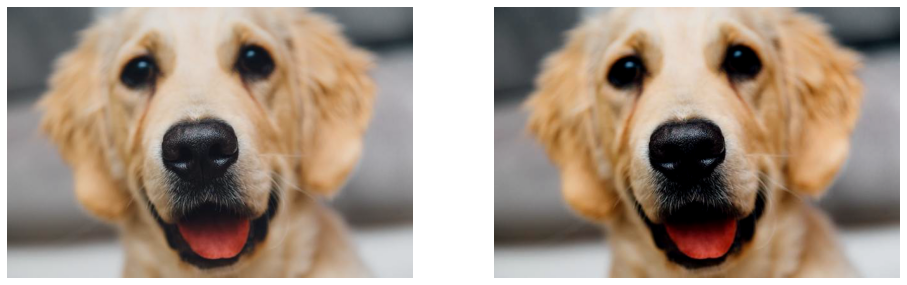

In [5]:
show(NormalizeScaleShift, 1)

### Directional reductions
In case of multidimensional data, it may be useful to calculate the mean and standard deviation only for a subset of dimensions. For example, the dimesnions may correspond to height (0), width (1) and color channels (2) of an image. Reducing the dimensions 0, 1 (height, width) will produce a separate mean and standard deviation for each channel.
`Normalize` supports two arguments to specify directions:

* `axes` - a tuple of dimension indices, 0 being outermost
* `axis_names` - axis symbols looked up in the input layout

The example below normalizes the data along WC, H, WH and C. 

In [6]:
class NormalizeDirectional(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(NormalizeDirectional, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(file_root=image_filename)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        self.normwc  = ops.Normalize(device="gpu", axes = (1, 2), scale=64, shift=128, dtype=types.UINT8)
        self.normh  = ops.Normalize(device="gpu", axis_names = "H", scale=64, shift=128, dtype=types.UINT8)
        self.normhw = ops.Normalize(device="gpu", axis_names = "HW", scale=64, shift=128, dtype=types.UINT8)
        self.normc  = ops.Normalize(device="gpu", axes = (2,), scale=64, shift=128, dtype=types.UINT8)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        return [image, self.normwc(image), self.normh(image), self.normhw(image), self.normc(image)]

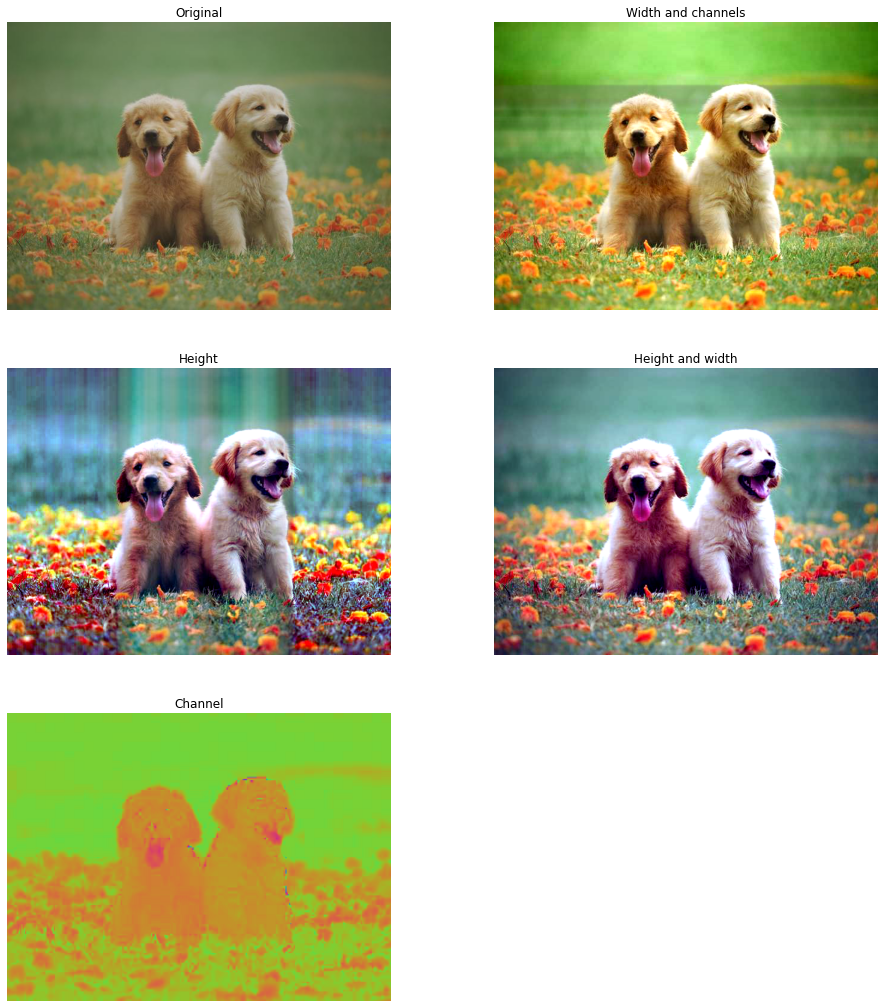

In [7]:
titles = ["Original", "Width and channels", "Height", "Height and width", "Channel"]
show(NormalizeDirectional, 9, captions = titles)

## Externally provided parameters
By default, `Normalize` calculates the mean and standard deviation internally - however, they can be provided externally via `mean` and `stddev` arguments. These arguments can be either scalar values or inputs. When providing `mean` or `stddev` as inputs, the directions of reduction can be inferred from parameter's shape. If both `mean` and `stddev` are inputs, they must have the same shapes.

In [8]:
class NormalizeWithParam(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(NormalizeWithParam, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(file_root=image_filename)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        
        self.norm_mean  = ops.Normalize(device="gpu", mean=64,
                                        axis_names="HW", scale=64, shift=128, dtype=types.UINT8)
        
        self.norm_stddev  = ops.Normalize(device="gpu", stddev=200,
                                          axis_names="HW", scale = 64, shift=128, dtype=types.UINT8)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        return [image, self.norm_mean(image), self.norm_stddev(image)]

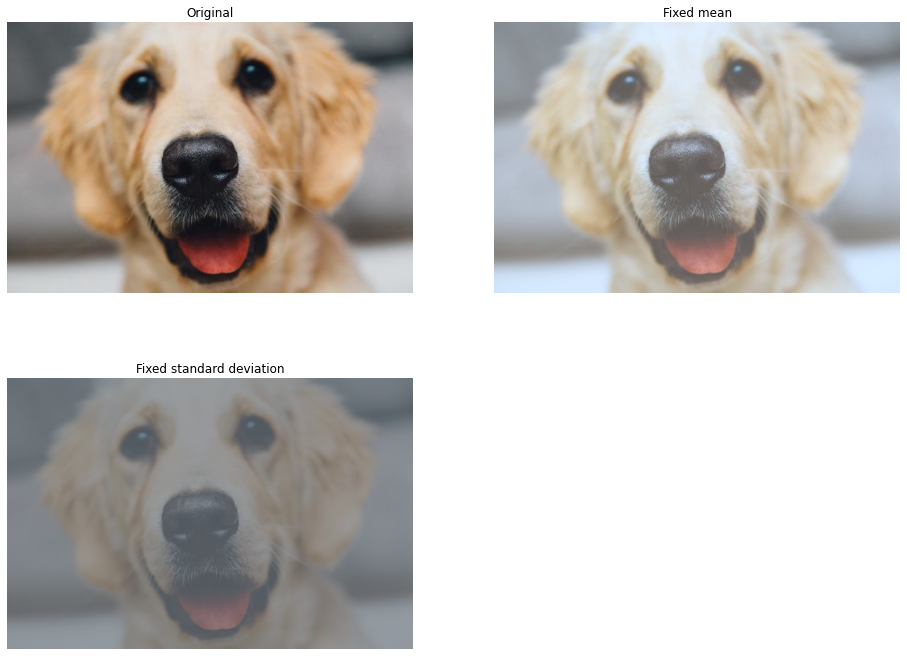

In [9]:
show(NormalizeWithParam, 1, captions = ["Original", "Fixed mean", "Fixed standard deviation"])

## Batch normalization
`Normalize` can calculate the mean and standard deviation for the whole batch instead of per-item. We can enable this behavior by setting `batch` argument to `True`. Batch normalization demands that the extents of non-reduced dimensions match for all samples in the batch. For example, the pipeline below expects that all images have three channels, because we're normalizing channels separately.

In [10]:
class NormalizeBatch(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(NormalizeBatch, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(file_root=image_filename)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        
        self.norm_sample  = ops.Normalize(device="gpu", batch=False,
                                          axis_names="HW", scale=64, shift=128, dtype=types.UINT8)
        
        self.norm_batch  = ops.Normalize(device="gpu", batch=True, axis_names="HW",
                                         scale = 64, shift=128, dtype=types.UINT8)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        return [image, self.norm_sample(image), self.norm_batch(image)]

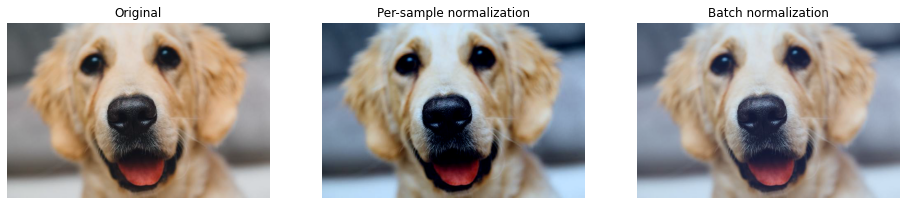

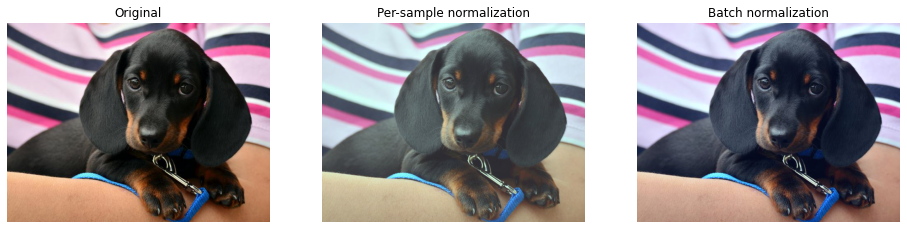

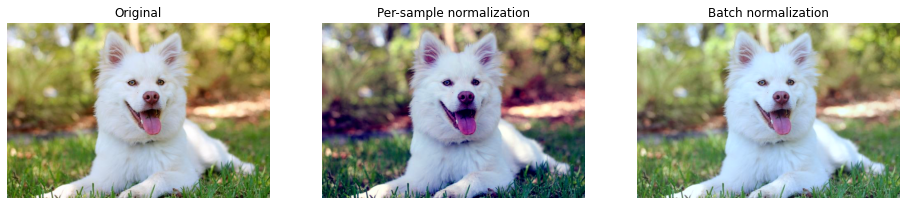

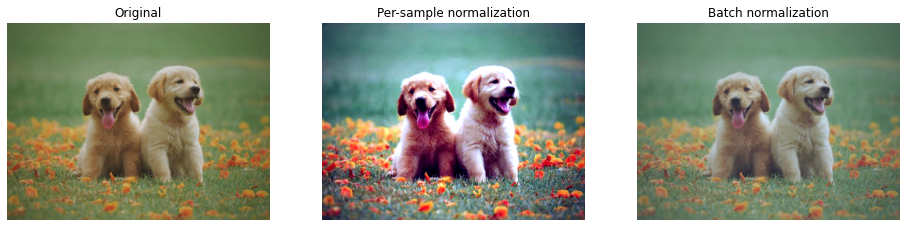

In [11]:
show(NormalizeBatch, 1, columns = 3, captions = ["Original", "Per-sample normalization", "Batch normalization"])
show(NormalizeBatch, 4, columns = 3, captions = ["Original", "Per-sample normalization", "Batch normalization"])
show(NormalizeBatch, 7, columns = 3, captions = ["Original", "Per-sample normalization", "Batch normalization"])
show(NormalizeBatch, 9, columns = 3, captions = ["Original", "Per-sample normalization", "Batch normalization"])